In [5]:
import numpy as np
import math
import os
import scipy as sp
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
from datetime import datetime
import pandas as pd
import glob
%matplotlib inline

In [20]:
path = '/Users/tjrempel/dataIncubator/Data'
files = glob.glob(path + "/*.csv")[:2]
months = ['JAN','FEB']

In [22]:
taxiData = []
for f in files:
    df = pd.read_csv(f)
    taxiData.append(df)

/Users/tjrempel/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [23]:
taxi = pd.concat(taxiData, keys = months)

In [24]:
striped_columns = []
for x in taxi.columns:
    striped_columns.append(x.strip())

In [25]:
taxi.columns = striped_columns

In [26]:
#Ensure that trip distance is positive
taxi = taxi[taxi["trip_distance"]> 0.1]

In [27]:
'''
Converts values in pickup and dropoff columns froms strings to datetime obejcts
'''
def convert_time(in_frame):
    in_frame["pickup_datetime"] = in_frame["pickup_datetime"].apply(lambda x: \
                datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    in_frame["dropoff_datetime"] = in_frame["dropoff_datetime"].apply(lambda x: \
                datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    return None

In [28]:
convert_time(taxi)

In [29]:
'''
Computes the average speed for a trip and appends to the end of the data frame
'''

def get_average_speed(in_frame):
    t1 = in_frame["pickup_datetime"]
    t2 = in_frame["dropoff_datetime"]
    deltaT = (t2-t1).apply(lambda x: x/np.timedelta64(1,'h'))
    avg_speed = in_frame["trip_distance"]/deltaT
    in_frame["avg_speed"] = pd.Series(avg_speed)
    return None

In [30]:
get_average_speed(taxi)

In [31]:
'''
Some of the trips have an infinite average speed, we will exclude those rows
'''
taxi = taxi.replace([np.inf,-np.inf],np.nan).dropna(subset = ['avg_speed'], how = 'all');

In [32]:
'''
There are also some spurious data points which given negative speed or speeds which are unrealistically high,
we wille exclude these rows as well
'''
taxi = taxi[(taxi["avg_speed"] > 0) & (taxi["avg_speed"] < 100)]

In [33]:
'''
We would like to get an idea for how certain quantities vary with pick up time so we will round 
each pickup time to the nearest hour
'''
def round_time (time):
    hour = time.hour
    minute = time.minute
    if minute >= 30:
        hour += 1
    return hour%24
def get_hours_and_dist(in_frame):
    in_frame["pickup_datetime"] = in_frame["pickup_datetime"].apply(lambda x: round_time(x))
    #in_frame["trip_distance"] = in_frame["trip_distance"].apply(lambda x: math.ceil(x*2)/2)
    return None

In [34]:
get_hours_and_dist(taxi)

In [35]:
'''
We want to examine the tipping behaviour of New Yorkers, but cash tips aren't recorded so we will only look at 
payments with credit cards
'''
tips = taxi[taxi["payment_type"]=="CRD"]

In [80]:
'''
Our first plot will be a rough info graphic of when the best time of day is to catch a taxi and sepifically for
trips to the airport. We will also include a figure showing the relative popularity of JFk vs Newark. 
'''

#For each pickup time get the median speed and total number of pick-ups
times = taxi.groupby("pickup_datetime").aggregate(np.median)
number= taxi.groupby("pickup_datetime").aggregate(np.size)


#Restrict to just JFK and Newark airport
jfk = taxi[(taxi["rate_code"] == 2) ]
newark = taxi[(taxi["rate_code"] == 3) ]
jfk_speed = jfk.groupby("pickup_datetime").aggregate(np.median)
newark_speed = newark.groupby("pickup_datetime").aggregate(np.median)
jfk_count = jfk.groupby("pickup_datetime").aggregate(np.size)
newark_count = newark.groupby("pickup_datetime").aggregate(np.size)

In [77]:
'''
Our first plot will be a rough info-graphic of when the best time of day is to catch a taxi and sepifically for
trips to the airport. We will also include a figure showing the relative popularity of JFk vs Newark. 
'''

#For each pickup time get the median speed and total number of pick-ups
times = taxi.groupby("pickup_datetime").aggregate(np.median)
number= taxi.groupby("pickup_datetime").aggregate(np.size)


#Restrict the above to just JFK and Newark airport
jfk_speed = times[times["rate_code"]==2]
newark_speed = times[times["rate_code"]==3]
jfk_count = number[number["rate_code"]==2]
newark_count = number[number["rate_code"]==3]

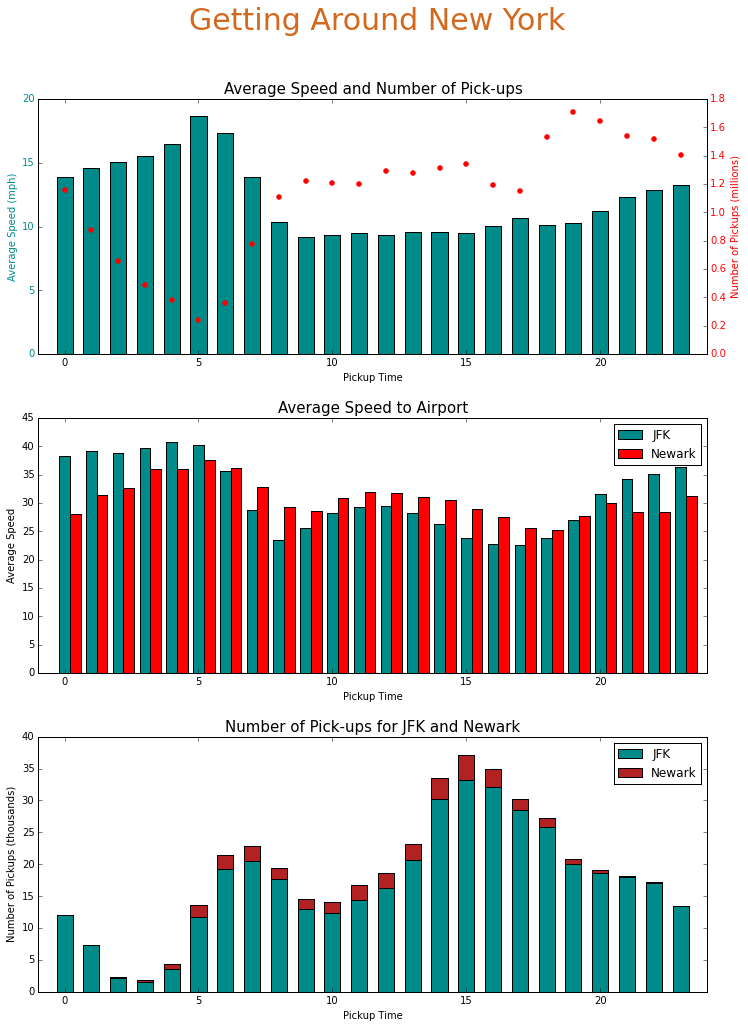

In [209]:
#Instantiate the figure
fig = plt.figure(figsize = (16, 16))
gs = mpl.gridspec.GridSpec(3, 1, width_ratios=[3,1])
gs.update(hspace = 0.25)

'''
First plot is average speed as a function of time as a bar graph referencing the left axis, with total number
of pickups overlayed as a scatter plot referencing the right axis
'''
ax1 = plt.subplot(gs[0])
width1 = 0.6

#Bar graph
ax1.bar(times.index,times["avg_speed"],width1, align = "center",color = 'darkcyan')
ax1.set_xlabel("Pickup Time")
ax1.set_ylabel("Average Speed (mph)",color = 'darkcyan')
for tl in ax1.get_yticklabels():
    tl.set_color('darkcyan')
    

#Scatter plot
ax12 = ax1.twinx()
ax12.scatter(number.index, number["tip_amount"]/1E6,color = 'r')
for t2 in ax12.get_yticklabels():
    t2.set_color('r')

ax12.set_ylabel("Number of Pickups (millions)", color = 'r')

ax1.set_title("Average Speed and Number of Pick-ups", fontsize = 15)


'''
Second plot is the average speed to each airport as a function of time of day. Speeds for each airport are
plotted as side-by-side bar graphs
'''


ax2 = plt.subplot(gs[1],sharex =ax1)
N = len(jfk_speed)
width2 = 0.4


jfkP = ax2.bar(jfk_speed.index,jfk_speed["avg_speed"], width2, color = 'darkcyan', align = "center" )
newarkP = ax2.bar(newark_speed.index + width2, newark_speed["avg_speed"],width2, color = 'r',align = "center")

ax2.set_ylabel("Average Speed")
ax2.set_xlabel("Pickup Time")


ax2.set_title("Average Speed to Airport", fontsize = 15)
ax2.legend((jfkP[0], newarkP[0]), ('JFK', 'Newark'), loc = 1)
ax2.set_xlim(-1,25)


'''
Third plot shows the total number of pick-ups as a function of the time of day to each airport, to show relative
popularity of each airport we plot as a stacked bar graph
'''

ax3 = plt.subplot(gs[2],sharex = ax1)
#First JFK
ax3.bar(jfk_count.index, jfk_count["tip_amount"]/1E3,width1,color = 'darkcyan', label = 'JFK', align = 'center')

#Now Newark 
ax3.bar(newark_count.index, newark_count["tip_amount"]/1E3,width1,color = 'firebrick', \
        bottom = jfk_count["tip_amount"]/1E3, label = 'Newark', align = 'center')
ax3.legend(loc = 1)
ax3.set_xlabel("Pickup Time")
ax3.set_ylabel("Number of Pickups (thousands)")
ax3.set_title("Number of Pick-ups for JFK and Newark", fontsize = 15)


plt.xlim(-1,24)
plt.suptitle("Getting Around New York", fontsize = 30, color = 'chocolate',x=0.42);
fig.savefig("gettingaround.png")

In [199]:
'''
Our second plot will give a snap shot of what Newyorkers are like. How much do they tip? How far, on average, do they
travel from pickup to drop off? Do they like to share cabs? 
'''

#Get the tip percentage - ignore extreme tip amounts which we classify as those over 50%
percent = (tips["tip_amount"]/tips["fare_amount"]*1000).apply(round)/10
percent = percent[percent <= 50]

'''
Get the distance travelled. Found that the number of people travelling more than 35 miles was so insignificant as
to be not worth including
'''
distances = taxi[taxi["trip_distance"] <= 25]["trip_distance"]
median_dist = taxi["trip_distance"].median()



'''
Get the number of passengers in a cab. Ignore any number <= 0 as well as anything above 6 because there are so few
so as to be irrelevant. 
'''
pass_counts = taxi[taxi["passenger_count"] > 0]["passenger_count"]
passC = pass_counts[pass_counts < 7]

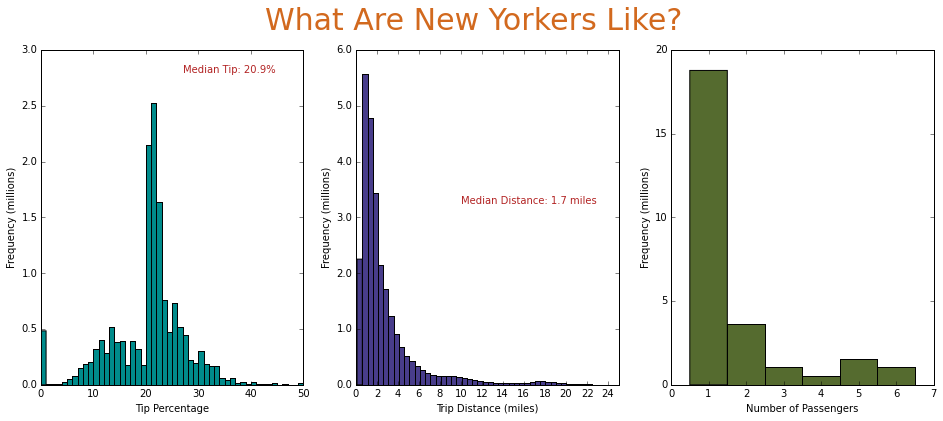

In [208]:
#Instantiate the figure
fig1 = plt.figure(figsize = (16, 6))
gs = mpl.gridspec.GridSpec(1, 3)

'''
First plot is the distribution of tip percentages, use 50 bins so each bin represents 1%.
'''
ax1 = plt.subplot(gs[0,0])

ax1 = percent.apply(round).hist(bins = 50, ylabelsize=10, grid = False, color ='darkcyan' )
#ax.set_xlim(0,51)
ax1.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, pos: ('%.1f')%(y*1e-6)))
ax1.set_ylabel("Frequency (millions)")
ax1.set_xlabel("Tip Percentage")
ax1.text(27,2.8E6,"Median Tip: " + "{:.1f}".format(percent.median())+"%", color = 'firebrick')
    

    
'''
Second plot is distribution of distances travelled, use 50 bins so each bin is a half mile. 
'''
ax2 = plt.subplot(gs[0,1])  
ax2 = distances.hist(bins = 50, grid = False, color = 'darkslateblue')
#ax2.set_xlim(0,25)
ax2.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, pos: ('%.1f')%(y*1e-6)))
ax2.set_ylabel("Frequency (millions)")
ax2.set_xlabel("Trip Distance (miles)")
ax2.set_xticks(range(0,25,2));
ax2.text(10,3.25E6,"Median Distance: " + "{:.1f}".format(median_dist)+" miles", color = 'firebrick')



'''
Third plot is distrubtion of number of passangers
'''
ax3 = plt.subplot(gs[0,2])  
ax3=passC.hist(bins = range(1,8),align = 'left',color = 'darkolivegreen', grid = False)
#ax3.set_xticks(b);
ax3.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, pos: ('%.0f')%(y*1e-6)))
ax3.set_ylabel("Frequency (millions)")
ax3.set_xlabel("Number of Passengers")
plt.suptitle("What Are New Yorkers Like?", fontsize = 30, color = 'chocolate',y=1)
fig1.savefig("newyorkers.png")